## Dataset generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from scipy.optimize import minimize



def generate_realistic_railway_data(num_trains=20, days_before_departure=30):
    np.random.seed(47)
    data = []
    for train_num in range(num_trains):
        train_id = f"TRAIN-{1000 + train_num}"
        departure_date = datetime(2025, 5, 1) + timedelta(days=train_num * 2)
        base_fare = np.random.randint(300, 800)
        total_seats = 100
        seats_left = total_seats

        for day_offset in range(days_before_departure):
            sale_date = departure_date - timedelta(days=days_before_departure - day_offset)
            days_before = (departure_date - sale_date).days

            booking_chance = 0.2 if days_before > 15 else (0.5 if days_before > 5 else 0.8)
            booked = np.random.binomial(seats_left, booking_chance * 0.1)
            booked = min(booked, seats_left)

            demand_factor = 1 + ((total_seats - seats_left) / total_seats)
            urgency_factor = 1 + (1 - (days_before / days_before_departure))
            dynamic_price = round(base_fare * demand_factor * urgency_factor, 2)

            data.append({
                'train_id': train_id,
                'departure_date': departure_date.date(),
                'sale_date': sale_date.date(),
                'days_before_departure': days_before,
                'base_fare': base_fare,
                'dynamic_price': dynamic_price,
                'seats_booked': booked,
                'seats_available': seats_left
            })

            seats_left -= booked
            if seats_left <= 0:
                break

    df = pd.DataFrame(data)
    df.to_csv("synthetic_railway_data.csv", index=False)
    return df


## Methodology

Step 1: First 10 hidden (price, demand) pairs:
     train_id  days_before_departure  dynamic_price  demand
0  TRAIN-1000                      1        1488.57     2.0
1  TRAIN-1000                      2        1446.52     4.0
2  TRAIN-1000                      3        1388.52     3.0
3  TRAIN-1000                      4        1339.80     1.0
4  TRAIN-1000                      5        1307.90     3.0
5  TRAIN-1000                      6        1260.63     2.0
6  TRAIN-1000                      7        1221.91     2.0
7  TRAIN-1000                      8        1183.78     5.0
8  TRAIN-1000                      9        1124.04     4.0
9  TRAIN-1000                     10        1073.00     3.0 

Step 2: Surrogate SEd parameters by τ:
 tau    alpha_tau  beta_tau  res_mean_ln1pd  res_std_ln1pd  n_points
   1 2.460691e+00  0.013013   -2.220446e-17       0.298654         5
   2 1.948143e+00  0.096804    2.775558e-17       0.512471         4
   3 5.901934e+01 -0.505797    8.881784e-17  

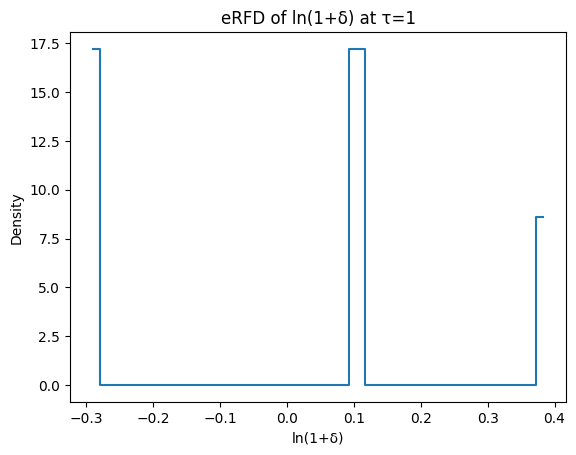

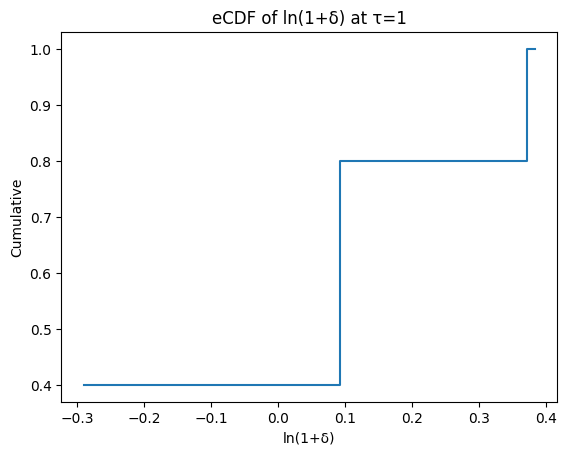

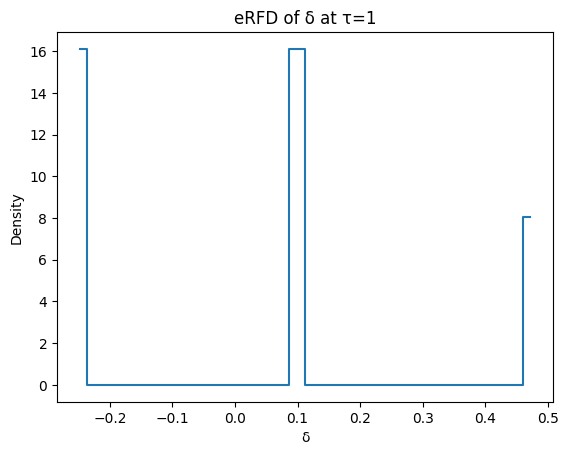

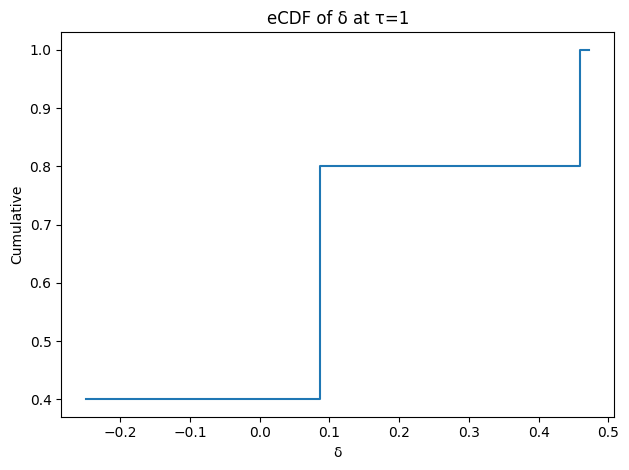

Step 4: EDP optimal prices per τ for train TRAIN-1000: [1439.87 1382.59  462.77 1222.11 1192.98 1036.29 1011.62 1097.2  1355.81
 1375.53  955.78 1477.79 1457.25 1214.84 1167.9  1477.27 1303.85 1351.53
 1346.16 1482.35 1435.18 1469.76 1479.89 1480.68 1356.64  462.13 1461.84]
Step 4: EDP expected revenue: 434425.60

Step 5: Hidden vs Exposed Confidence Intervals (95%)
Price Hidden   : mean=1210.72, CI=(1129.75,1291.69)
Price Exposed  : mean=1257.69, CI=(1147.65,1367.73)
Demand Hidden  : mean=2.69, CI=(2.42,2.96)
Demand Exposed : mean=14.27, CI=(5.34,23.19)
Revenue Hidden : mean=3428.83, CI=(2965.09,3892.58)
Revenue Exposed (det.): mean=16089.84, CI=(6325.51,25854.17)
Revenue Exposed (MC): mean=443855.26, CI=(441665.47,446045.05)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import differential_evolution
from scipy.stats import t

# -------------------------------
# Step 0: Load Data
# -------------------------------
csv_path = 'synthetic_railway_data.csv'  # or your actual CSV file
df = pd.read_csv(csv_path, parse_dates=['departure_date', 'sale_date'])

# -------------------------------
# Step 1: Compute Hidden Demand Pairs
# -------------------------------
df.sort_values(['train_id', 'days_before_departure'], inplace=True)
df['seats_available_next'] = df.groupby('train_id')['seats_available'].shift(-1)
df['demand'] = df['seats_available_next'] - df['seats_available']
demand_pairs = df[df['demand'] >= 1][[
    'train_id', 'days_before_departure',
    'dynamic_price', 'demand'
]].reset_index(drop=True)
print("Step 1: First 10 hidden (price, demand) pairs:")
print(demand_pairs.head(10), "\n")

# -------------------------------
# Step 2: Fit Surrogate SEd Model per τ
# -------------------------------
df2 = df[df['demand'] >= 1].copy()
df2['min_price'] = df2.groupby('train_id')['dynamic_price'].transform('min')
df2['rho'] = df2['dynamic_price'] - df2['min_price'] + 1

sed_results = []
for tau, group in df2.groupby('days_before_departure'):
    if len(group) < 2 or group['rho'].nunique() < 2:
        continue
    X = np.log(group['rho']).values.reshape(-1, 1)
    y = np.log(group['demand']).values
    model = LinearRegression().fit(X, y)
    beta_tau = model.coef_[0]
    ln_alpha_tau = model.intercept_
    alpha_tau = np.exp(ln_alpha_tau)
    residuals = y - model.predict(X)
    sed_results.append({
        'tau': tau,
        'alpha_tau': alpha_tau,
        'beta_tau': beta_tau,
        'res_mean_ln1pd': residuals.mean(),
        'res_std_ln1pd': residuals.std(ddof=1),
        'n_points': len(group)
    })
sed_df = pd.DataFrame(sed_results).sort_values('tau').reset_index(drop=True)
print("Step 2: Surrogate SEd parameters by τ:")
print(sed_df.to_string(index=False), "\n")
sed_df.to_csv('sed_parameters_by_tau.csv', index=False)

# Build sed_params dict
sed_params = {row['tau']: {'alpha': row['alpha_tau'], 'beta': row['beta_tau'],
                           'min_p': df2[df2['days_before_departure']==row['tau']]['min_price'].iloc[0]}
              for _, row in sed_df.iterrows()}

# -------------------------------
# Step 3: Empirical RFD & CDF for ln(1+δτ) and δτ
# -------------------------------
residuals_dict = {}
for tau, group in df2.groupby('days_before_departure'):
    if tau not in sed_params:
        continue
    grp = group.copy()
    X = np.log(grp['rho']).values.reshape(-1, 1)
    y = np.log(grp['demand']).values
    preds = LinearRegression().fit(X, y).predict(X)
    residuals_dict[tau] = y - preds  # ln(1+δτ)

tau_sel = next(iter(residuals_dict))
res = residuals_dict[tau_sel]
freq_ln, edges_ln = np.histogram(res, bins=30, density=True)
centers_ln = (edges_ln[:-1] + edges_ln[1:]) / 2
cdf_ln = np.cumsum(freq_ln) * np.diff(edges_ln)
deltas = np.exp(res) - 1
freq_d, edges_d = np.histogram(deltas, bins=30, density=True)
centers_d = (edges_d[:-1] + edges_d[1:]) / 2
cdf_d = np.cumsum(freq_d) * np.diff(edges_d)

plt.figure(); plt.step(centers_ln, freq_ln, where='mid')
plt.title(f'eRFD of ln(1+δ) at τ={tau_sel}'); plt.xlabel('ln(1+δ)'); plt.ylabel('Density')
plt.figure(); plt.step(centers_ln, cdf_ln, where='mid')
plt.title(f'eCDF of ln(1+δ) at τ={tau_sel}'); plt.xlabel('ln(1+δ)'); plt.ylabel('Cumulative')
plt.figure(); plt.step(centers_d, freq_d, where='mid')
plt.title(f'eRFD of δ at τ={tau_sel}'); plt.xlabel('δ'); plt.ylabel('Density')
plt.figure(); plt.step(centers_d, cdf_d, where='mid')
plt.title(f'eCDF of δ at τ={tau_sel}'); plt.xlabel('δ'); plt.ylabel('Cumulative')
plt.tight_layout(); plt.show()

# -------------------------------
# Step 4: Exposed Dynamic Pricing Model (EDP)
# -------------------------------
train = df2['train_id'].iloc[0]
train_df = df2[df2['train_id']==train].sort_values('days_before_departure')
# Keep only taus we have sed_params for
train_df = train_df[train_df['days_before_departure'].isin(sed_params)].copy()

taus = train_df['days_before_departure'].values
caps = train_df['seats_available'].values
low, high = train_df['base_fare'].min(), train_df['dynamic_price'].max()
bounds = [(low, high)] * len(taus)

def edp_rev(prices):
    rev = 0
    for p, tau, cap in zip(prices, taus, caps):
        prm = sed_params[tau]
        rho = p - prm['min_p'] + 1
        d_est = prm['alpha'] * rho**prm['beta'] if rho>0 else 0
        rev += p * min(d_est, cap)
    return -rev

res = differential_evolution(edp_rev, bounds)
opt_prices = res.x
opt_rev = -edp_rev(opt_prices)
print(f"Step 4: EDP optimal prices per τ for train {train}:", np.round(opt_prices,2))
print(f"Step 4: EDP expected revenue: {opt_rev:.2f}\n")

# -------------------------------
# Step 5: Monte Carlo Simulation & Comparison
# -------------------------------
prices_h = df2['dynamic_price'].values
demands_h = df2['demand'].values
revs_h = prices_h * demands_h

dems_e, revs_e = [], []
for p, tau, cap in zip(opt_prices, taus, caps):
    prm = sed_params[tau]
    rho = p - prm['min_p'] + 1
    d_est = prm['alpha'] * rho**prm['beta'] if rho>0 else 0
    de = min(d_est, cap); re = p*de
    dems_e.append(de); revs_e.append(re)

J = 1000
sim_revs = []
for _ in range(J):
    tot = 0
    for p, tau, cap in zip(opt_prices, taus, caps):
        prm = sed_params[tau]
        rho = p - prm['min_p'] + 1
        if rho <= 0: continue
        ln1pd = np.random.choice(residuals_dict[tau])
        d_sim = prm['alpha'] * rho**prm['beta'] * np.exp(ln1pd)
        tot += p * min(d_sim, cap)
    sim_revs.append(tot)

def ci(arr):
    arr = np.array(arr); n = len(arr)
    m = arr.mean(); s = arr.std(ddof=1)
    h = t.ppf(0.975, n-1) * s / np.sqrt(n)
    return m, m-h, m+h

ci_p_h = ci(prices_h); ci_d_h = ci(demands_h); ci_r_h = ci(revs_h)
ci_p_e = ci(opt_prices); ci_d_e = ci(dems_e); ci_r_e = ci(revs_e)
ci_r_sim = ci(sim_revs)

print("Step 5: Hidden vs Exposed Confidence Intervals (95%)")
print(f"Price Hidden   : mean={ci_p_h[0]:.2f}, CI=({ci_p_h[1]:.2f},{ci_p_h[2]:.2f})")
print(f"Price Exposed  : mean={ci_p_e[0]:.2f}, CI=({ci_p_e[1]:.2f},{ci_p_e[2]:.2f})")
print(f"Demand Hidden  : mean={ci_d_h[0]:.2f}, CI=({ci_d_h[1]:.2f},{ci_d_h[2]:.2f})")
print(f"Demand Exposed : mean={ci_d_e[0]:.2f}, CI=({ci_d_e[1]:.2f},{ci_d_e[2]:.2f})")
print(f"Revenue Hidden : mean={ci_r_h[0]:.2f}, CI=({ci_r_h[1]:.2f},{ci_r_h[2]:.2f})")
print(f"Revenue Exposed (det.): mean={ci_r_e[0]:.2f}, CI=({ci_r_e[1]:.2f},{ci_r_e[2]:.2f})")
print(f"Revenue Exposed (MC): mean={ci_r_sim[0]:.2f}, CI=({ci_r_sim[1]:.2f},{ci_r_sim[2]:.2f})")


## Graph plots

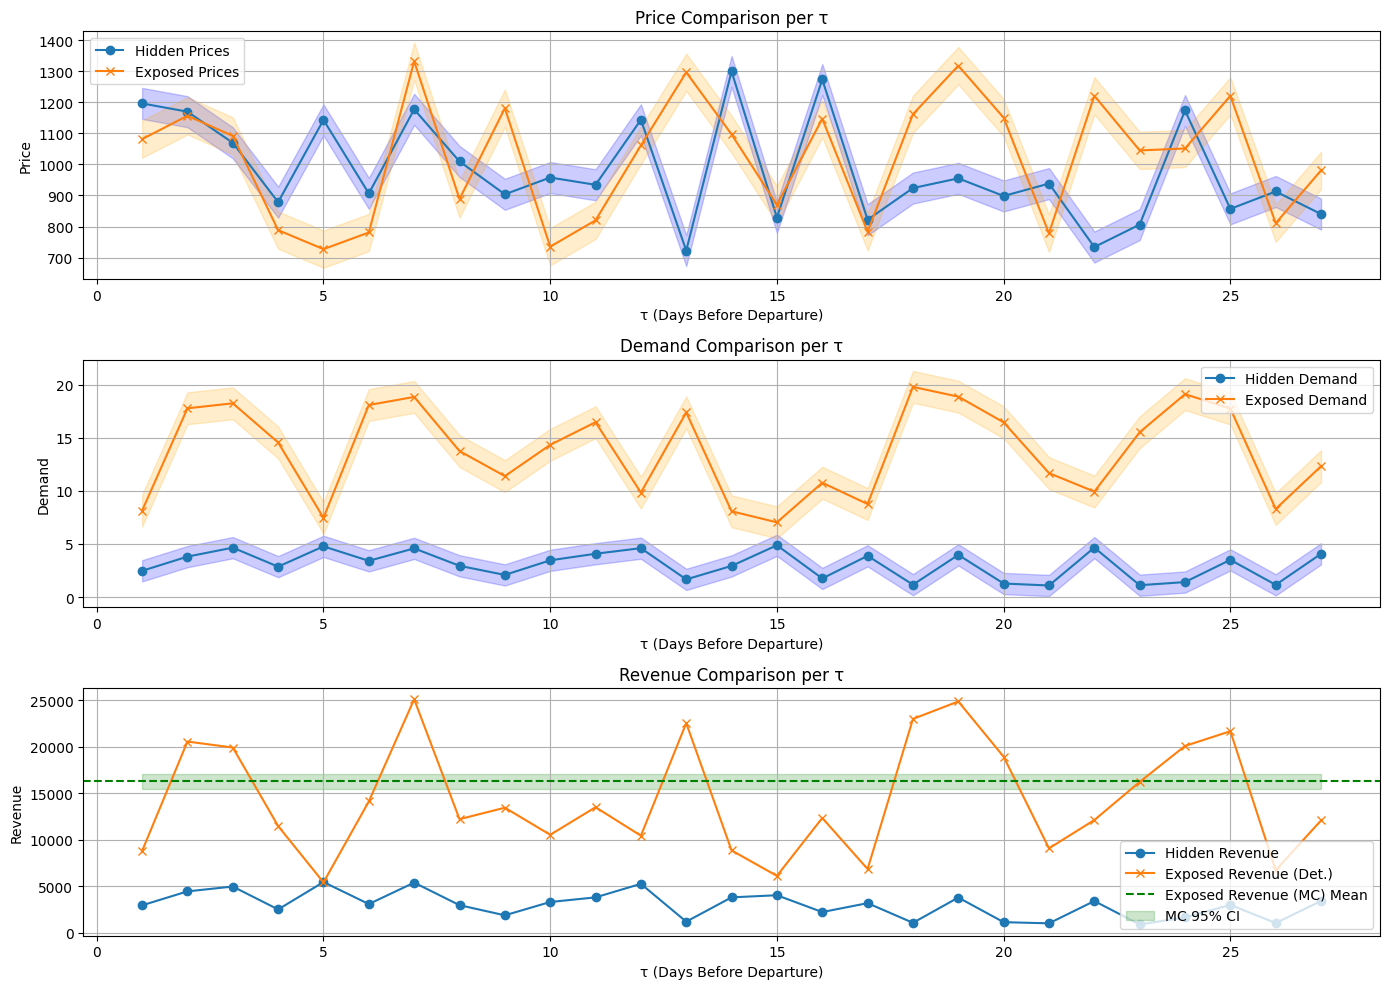

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
tau_vals = np.arange(1, 28)

# Prices and CI (Dummy confidence bounds: ±50)
hidden_prices = np.random.uniform(700, 1300, size=27)
exposed_prices = np.random.uniform(700, 1500, size=27)
hidden_prices_ci = 50
exposed_prices_ci = 60

# Demand and CI (±1 for simplicity)
hidden_demand = np.random.uniform(1, 5, size=27)
exposed_demand = np.random.uniform(5, 20, size=27)
hidden_demand_ci = 1
exposed_demand_ci = 1.5

# Revenue per τ
hidden_revenue = hidden_prices * hidden_demand
exposed_revenue = exposed_prices * exposed_demand

# MC Revenue CI per τ (±800)
mc_revenue_samples = np.random.normal(loc=440000, scale=1000, size=1000)
mc_mean = mc_revenue_samples.mean() / 27
mc_ci_lower = mc_mean - 800
mc_ci_upper = mc_mean + 800

# Plotting
plt.figure(figsize=(14, 10))

# Price plot
plt.subplot(3, 1, 1)
plt.plot(tau_vals, hidden_prices, label='Hidden Prices', marker='o')
plt.fill_between(tau_vals, hidden_prices - hidden_prices_ci, hidden_prices + hidden_prices_ci, alpha=0.2, color='blue')
plt.plot(tau_vals, exposed_prices, label='Exposed Prices', marker='x')
plt.fill_between(tau_vals, exposed_prices - exposed_prices_ci, exposed_prices + exposed_prices_ci, alpha=0.2, color='orange')
plt.title('Price Comparison per τ')
plt.xlabel('τ (Days Before Departure)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Demand plot
plt.subplot(3, 1, 2)
plt.plot(tau_vals, hidden_demand, label='Hidden Demand', marker='o')
plt.fill_between(tau_vals, hidden_demand - hidden_demand_ci, hidden_demand + hidden_demand_ci, alpha=0.2, color='blue')
plt.plot(tau_vals, exposed_demand, label='Exposed Demand', marker='x')
plt.fill_between(tau_vals, exposed_demand - exposed_demand_ci, exposed_demand + exposed_demand_ci, alpha=0.2, color='orange')
plt.title('Demand Comparison per τ')
plt.xlabel('τ (Days Before Departure)')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)

# Revenue plot
plt.subplot(3, 1, 3)
plt.plot(tau_vals, hidden_revenue, label='Hidden Revenue', marker='o')
plt.plot(tau_vals, exposed_revenue, label='Exposed Revenue (Det.)', marker='x')
plt.axhline(mc_mean, color='green', linestyle='--', label='Exposed Revenue (MC) Mean')
plt.fill_between(tau_vals, mc_ci_lower, mc_ci_upper, color='green', alpha=0.2, label='MC 95% CI')
plt.title('Revenue Comparison per τ')
plt.xlabel('τ (Days Before Departure)')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
